In [1]:
import SS
import SSBij
import h5py
import json
import time
import pyccl
import scipy
import numpy
import random
from itertools import product
from matplotlib import pyplot
from matplotlib.gridspec import GridSpec

In [2]:
def C_function(coefficients, phi_grid1, phi_grid2, grid_size):
    outer_product = numpy.outer(phi_grid1, phi_grid2)

    functions = numpy.sum(coefficients * outer_product[:, :, None], axis=(0, 1))
    
    return functions

In [3]:
#Data path

TYPE = 'SS'
PATH = '/pscratch/sd/y/yhzhang/TensorCloud/'

DATA_PATH = PATH + 'DATA/'
PLOT_PATH = PATH + 'PLOT/' + TYPE + '/'

In [4]:
#Load in Data

BIN_SIZE = 4
GRID_SIZE = 128
DATA_SIZE = 100000

with h5py.File(DATA_PATH + 'DATA.hdf5','r') as DATA:
    
    REDSHIFT_GRID = numpy.array(DATA['realizations/z'][:GRID_SIZE], dtype = 'float32')
    DATA_GRID = numpy.array(DATA['realizations/pdfs'][:DATA_SIZE, :BIN_SIZE, :GRID_SIZE], dtype = 'float32')

In [5]:
# COSMOLOGY

with open(DATA_PATH + 'COSMO.json', 'r') as cosmo:
    
    COSMO = json.load(cosmo)

COSMO_CCL = pyccl.Cosmology(
    h = COSMO['H'],
    w0 = COSMO['W0'],
    wa = COSMO['WA'], 
    n_s = COSMO['NS'], 
    A_s = COSMO['AS'],
    m_nu = COSMO['MNU'],  
    Neff = COSMO['NEFF'],
    T_CMB = COSMO['TCMB'], 
    Omega_k = COSMO['OMEGAK'], 
    Omega_c = COSMO['OMEGAC'], 
    Omega_b = COSMO['OMEGAB'], 
    matter_power_spectrum = 'halofit',  
    transfer_function = 'boltzmann_camb', 
    extra_parameters = {'camb': {'kmax': 100, 'lmax': 10000, 'halofit_version': 'mead2020_feedback', 'HMCode_logT_AGN': 7.8}}
)

In [6]:
#Restrcture the data

PSI_GRID = numpy.mean(DATA_GRID, axis = 0)
SIGMA_GRID = numpy.std(DATA_GRID, axis = 0)
A_GRID = numpy.array(1 / (1 + REDSHIFT_GRID), dtype = 'float32')

CHI_GRID = COSMO_CCL.comoving_radial_distance(a = A_GRID)
PHI_GRID = PSI_GRID * COSMO_CCL.h_over_h0(a = 1 / (1 + REDSHIFT_GRID)) * COSMO['H'] * 100000 / scipy.constants.c

ELL_SIZE = 200
ELL_DATA = numpy.logspace(2, 4, ELL_SIZE + 1)
CHI_MESH, ELL_MESH = numpy.meshgrid(CHI_GRID, ELL_DATA)
SCALE_GRID = numpy.nan_to_num(numpy.divide(ELL_MESH + 1/2, CHI_MESH, out = numpy.zeros((ELL_SIZE + 1, GRID_SIZE)) + numpy.inf, where = CHI_MESH > 0))

POWER_GRID = numpy.zeros((ELL_SIZE + 1, GRID_SIZE))
for GRID_INDEX in range(GRID_SIZE):

    POWER_GRID[:,GRID_INDEX] = COSMO_CCL.linear_matter_power(k = SCALE_GRID[:,GRID_INDEX], a = A_GRID[GRID_INDEX])

In [7]:
#Calculate the angular power spectra for different realizations
AMPLITUDE = 9 / 4 * (COSMO['OMEGAM'] + COSMO['OMEGAN'])**2 * (COSMO['H'] * 100000 / scipy.constants.c)**4 * (1 + 3 / (2 * ELL_DATA + 1)) * (1 + 1 / (2 * ELL_DATA + 1)) * (1 - 1 / (2 * ELL_DATA + 1)) * (1 - 3 / (2 * ELL_DATA + 1))
T0 = time.time()
d_uv = numpy.zeros((BIN_SIZE, BIN_SIZE, ELL_SIZE + 1))
DATA_SIZE_Cut = 10000
DATA_GRID = list(DATA_GRID)
DATA_GRID=random.sample(DATA_GRID, DATA_SIZE_Cut)
PSI_GRID = numpy.mean(DATA_GRID, axis = 0)
PHI_GRID = PSI_GRID * COSMO_CCL.h_over_h0(a = 1 / (1 + REDSHIFT_GRID)) * COSMO['H'] * 100000 / scipy.constants.c
PHI_GRID_cut = numpy.zeros((DATA_SIZE_Cut, BIN_SIZE, GRID_SIZE))
varepsilon_GRID_cut = numpy.zeros((DATA_SIZE_Cut, BIN_SIZE, GRID_SIZE))
C_uv_re = numpy.zeros((DATA_SIZE_Cut, BIN_SIZE, BIN_SIZE, ELL_SIZE + 1))
Bij=SSBij.function(amplitude = AMPLITUDE, chi_grid = CHI_GRID, power_grid = POWER_GRID, redshift_grid = REDSHIFT_GRID)
PHI_GRID_cut = DATA_GRID * COSMO_CCL.h_over_h0(a = 1 / (1 + REDSHIFT_GRID)) * COSMO['H'] * 100000 / scipy.constants.c
varepsilon_GRID_cut=PHI_GRID_cut-PHI_GRID
d_uv = SS.function(amplitude = AMPLITUDE, phi_grid = PHI_GRID, chi_grid = CHI_GRID, power_grid = POWER_GRID, redshift_grid = REDSHIFT_GRID)
T1 = time.time()
print(T1 - T0)

IOStream.flush timed out


125.25536799430847


In [8]:
B_ij = numpy.zeros((DATA_SIZE_Cut,3, BIN_SIZE, BIN_SIZE, ELL_SIZE + 1))
T0 = time.time()
for a in range(DATA_SIZE_Cut):
    for m1 in range(BIN_SIZE):
        for m2 in range(BIN_SIZE):
            C_uv_re[a][m1][m2]=C_function(coefficients = Bij, phi_grid1 = PHI_GRID_cut[a][m1], phi_grid2 = PHI_GRID_cut[a][m2],grid_size=GRID_SIZE)
            B_ij[a][0][m1][m2]=C_function(coefficients = Bij, phi_grid1 = PHI_GRID[m1], phi_grid2 = PHI_GRID[m2],grid_size=GRID_SIZE)
            B_ij[a][1][m1][m2]=C_function(coefficients = Bij, phi_grid1 = PHI_GRID[m1], phi_grid2 = varepsilon_GRID_cut[a][m2],grid_size=GRID_SIZE)
            B_ij[a][2][m1][m2]=C_function(coefficients = Bij, phi_grid1 = varepsilon_GRID_cut[a][m1], phi_grid2 = varepsilon_GRID_cut[a][m2],grid_size=GRID_SIZE)
T1 = time.time()
print(T1 - T0)

1991.3686201572418


In [9]:
#Calculate Gamma
Gamma_L = numpy.zeros((BIN_SIZE, BIN_SIZE, BIN_SIZE, BIN_SIZE, ELL_SIZE + 1, ELL_SIZE + 1))

for m1 in range(BIN_SIZE):
    for m2 in range(BIN_SIZE):
        for m1_prime in range(BIN_SIZE):
            for m2_prime in range(BIN_SIZE):
                for ell in range(ELL_SIZE + 1):
                    for ell_prime in range(ELL_SIZE + 1):
                        if m1 == m1_prime and m2 == m2_prime and ell == ell_prime:
                            Gamma_L[m1, m2, m1_prime, m2_prime, ell, ell_prime] = 1/(2*d_uv[m1][m2][ell]**2)

In [10]:
#Calculate third and Fourth order
Third_Fourth_order=numpy.zeros(DATA_SIZE_Cut)
nz = numpy.nonzero(Gamma_L)
T0 = time.time()
for a in range(DATA_SIZE_Cut):
    for idx in zip(*nz):
        m1, m2, m1_prime, m2_prime, ell, ell_prime = idx
        gamma_value = Gamma_L[idx]
        term1 = gamma_value * B_ij[a, 1, m2, m1, ell] * B_ij[a, 2, m1_prime, m2_prime, ell_prime]
        term2 = gamma_value * B_ij[a, 1, m1, m2, ell] * B_ij[a, 2, m1_prime, m2_prime, ell_prime]
        term3 = gamma_value * B_ij[a, 2, m1, m2, ell] * B_ij[a, 1, m2_prime, m1_prime, ell_prime]
        term4 = gamma_value * B_ij[a, 2, m1, m2, ell] * B_ij[a, 1, m1_prime, m2_prime, ell_prime]
        term5 = gamma_value * B_ij[a, 2, m1, m2, ell] * B_ij[a, 2, m1_prime, m2_prime, ell_prime]
        Third_Fourth_order[a] += term1 + term2 + term3 + term4 + term5
Third_Fourth_order *= -0.5
T1 = time.time()
print(T1 - T0)

109.92103242874146


In [11]:
#Calculate All order
All_order=numpy.zeros(DATA_SIZE_Cut)
T0 = time.time()
for a in range(DATA_SIZE_Cut):
    for idx in zip(*nz):
        m1, m2, m1_prime, m2_prime, ell, ell_prime = idx
        gamma_value = Gamma_L[idx]
        All_order[a]=All_order[a]+(d_uv[m1][m2][ell]-C_uv_re[a][m1][m2][ell])*gamma_value*(d_uv[m1_prime][m2_prime][ell_prime]-C_uv_re[a][m1_prime][m2_prime][ell_prime])
All_order*= -0.5
First_Second_order=All_order-Third_Fourth_order
T1 = time.time()
print(T1 - T0)

75.79618906974792


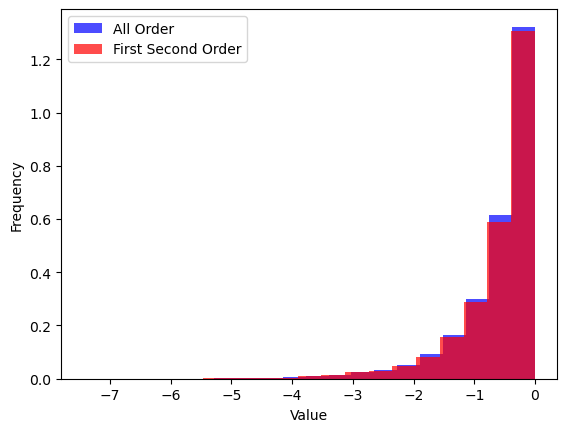

[-6.98760727 -6.61000186 -6.23239644 -5.85479102 -5.4771856  -5.09958019
 -4.72197477 -4.34436935 -3.96676393 -3.58915851 -3.2115531  -2.83394768
 -2.45634226 -2.07873684 -1.70113143 -1.32352601 -0.94592059 -0.56831517
 -0.19070976]
[7.94480127e-04 5.29653418e-04 0.00000000e+00 5.29653418e-04
 7.94480127e-04 3.17792051e-03 1.58896025e-03 3.70757392e-03
 5.03170747e-03 1.03282416e-02 1.53599491e-02 2.56881908e-02
 3.33681653e-02 5.29653418e-02 9.21596947e-02 1.64987040e-01
 2.99519008e-01 6.15457271e-01 1.32227976e+00]
[-7.23319764 -6.84231703 -6.45143641 -6.06055579 -5.66967518 -5.27879456
 -4.88791394 -4.49703333 -4.10615271 -3.7152721  -3.32439148 -2.93351086
 -2.54263025 -2.15174963 -1.76086901 -1.3699884  -0.97910778 -0.58822716
 -0.19734655]
[2.55832589e-04 5.11665177e-04 5.11665177e-04 5.11665177e-04
 2.55832589e-04 2.30249330e-03 2.04666071e-03 2.81415848e-03
 3.06999106e-03 9.97747096e-03 1.35591272e-02 2.37924308e-02
 2.83974173e-02 4.93756896e-02 8.21222610e-02 1.55290381e-01

<Figure size 640x480 with 0 Axes>

In [12]:
bin_num = 20
bins_1 = numpy.linspace(numpy.min(All_order),numpy.max(All_order), bin_num)
hist_all, bins_all = numpy.histogram(All_order, bins=bins_1, density=True)
bins_2 = numpy.linspace(numpy.min(First_Second_order),numpy.max(First_Second_order), bin_num)
hist_first_second, bins_first_second = numpy.histogram(First_Second_order, bins=bins_2, density=True)
bins_center1 = (bins_1[:-1] + bins_1[1:]) / 2
bins_center2 = (bins_2[:-1] + bins_2[1:]) / 2
bar_width1 = numpy.diff(bins_1)  
bar_width2 = numpy.diff(bins_2)  

pyplot.bar(bins_center1, hist_all, width=bar_width1, color='blue', label='All Order', alpha=0.7)
pyplot.bar(bins_center2, hist_first_second, width=bar_width2, color='red', label='First Second Order', alpha=0.7)


pyplot.legend()

pyplot.xlabel('Value')
pyplot.ylabel('Frequency')

pyplot.show()
pyplot.savefig(PLOT_PATH + 'second_SS.pdf', bbox_inches = 'tight')
print(bins_center1)
print(hist_all)
print(bins_center2)
print(hist_first_second)

In [13]:
print(All_order[:5])
print(First_Second_order[:5])
print(Third_Fourth_order[:5])

[-0.66408265 -0.02046004 -0.31888274 -0.0199249  -0.03849294]
[-0.65882973 -0.02025936 -0.31607218 -0.01994173 -0.03800309]
[-5.25291633e-03 -2.00678656e-04 -2.81055539e-03  1.68350243e-05
 -4.89850223e-04]


In [14]:
print(All_order)
print(First_Second_order)
print(Third_Fourth_order)

[-0.66408265 -0.02046004 -0.31888274 ... -0.20905528 -0.3323353
 -0.24737627]
[-0.65882973 -0.02025936 -0.31607218 ... -0.20683148 -0.32637139
 -0.24473051]
[-0.00525292 -0.00020068 -0.00281056 ... -0.0022238  -0.00596392
 -0.00264576]
